In [1]:
# %gui qt
%matplotlib notebook

# %qtconsole

import logging
import time

from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np

import qcodes
from qcodes.utils.helpers import LogCapture

In [2]:
%run -i ./init_station.py

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\pyvisa\ctwrapper\functions.py:1225: VisaIOWarning: VI_WARN_CONFIG_NLOADED (1073676407): The specified configuration either does not exist or could not be loaded. VISA-specified defaults will be used.
  ret = library.viOpenDefaultRM(byref(session))


Connected to: TEKTRONIX AWG5208 (serial:B020202, firmware:FV:6.1.0054.0) in 0.22s


In [3]:
setup_alazar_ext_trigger(384, 1, 1)

<IPython.core.display.Javascript object>


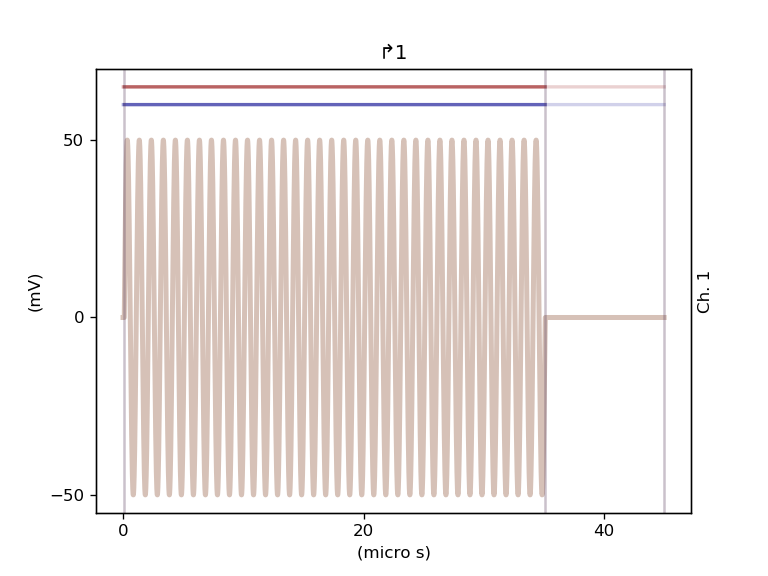

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


True

In [4]:
from alazar_benchmarking import benchmark
benchmark.make_test_sequence_5208(station.awg5208_1, plot=True)

In [5]:
ats_logger = qcodes.instrument_drivers.AlazarTech.ATS.logger
ats_logger.setLevel(logging.DEBUG)

# Define acquisition controllers

In [6]:
# from pytopo.rf.alazar_acquisition import BaseAcqCtl
from qcodes.instrument_drivers.AlazarTech.ATS import AcquisitionController

class BaseAcqCtl(AcquisitionController):
    """
    The baseclass for all the controllers in this file. Implements the basic
    getting of data but does not implement any of the data shaping,
    demodulation or averaging.
    """
    MINSAMPLES = 384
    CONVERT_TO_VOLTS = True

    def __init__(self, name, alazar_name, allocate_samples=0, **kwargs):
        self.acquisitionkwargs = {}
        self.number_of_channels = 2
        self.trigger_func = None
        self._average_buffers = False
        
        self._nbits = 12
        self._model = 'ATS9360'
        self._buffer_order = 'brsc'

        self.data = None
        self.tvals = None

        super().__init__(name, alazar_name, **kwargs)

        if self._alazar is not None:
            alz = self._alazar
            
            self.add_parameter('sample_rate', get_cmd=alz.sample_rate)
            self.add_parameter('samples_per_record', get_cmd=alz.samples_per_record)
            self.add_parameter('records_per_buffer', get_cmd=alz.records_per_buffer)
            self.add_parameter('buffers_per_acquisition', get_cmd=alz.buffers_per_acquisition)

            self.add_parameter('acq_time', get_cmd=None, set_cmd=None, unit='s', initial_value=None)
            
            self.add_parameter("acquisition", get_cmd=self.do_acquisition, snapshot_value=False)

            _idn = alz.IDN()
            self._nbits = _idn['bits_per_sample']
            self._model = _idn['model']
            
            if self._model == 'ATS9870':
                self._buffer_order = 'bcrs'

        else:
            self.add_parameter('sample_rate', set_cmd=None)
            self.add_parameter('samples_per_record', set_cmd=None)
            self.add_parameter('records_per_buffer', set_cmd=None)
            self.add_parameter('buffers_per_acquisition', set_cmd=None)

        if self._nbits == 8:
            self._datadtype = np.uint8
        elif self._nbits == 12:
            self._datadtype = np.uint16
        else:
            raise ValueError('Unsupported number of bits per samples:', self._nbits)
            
        if allocate_samples > 0:
            self.allocate_data(allocate_samples)

    def allocate_data(self, nsamples):
        print(f'Allocating {nsamples} elements ({self.samples2MB(nsamples)} MB)')
        self.data = np.zeros(nsamples, dtype=self._datadtype)      

    def setup_acquisition(self, samples_per_record, records, buffers, 
                          allocated_buffers=None, acq_time=None, SR=None):
        alazar = self._alazar
        
        if SR is None:
            SR = alazar.sample_rate()
        
        if allocated_buffers is None:
            nalloc = buffers
        else:
            nalloc = allocated_buffers
            
        if acq_time is not None:
            n_samples_per_record = int(acq_time * SR // 128 * 128)
        else:
            n_samples_per_record = int(samples_per_record)

        with alazar.syncing():
            alazar.sample_rate(SR)
            alazar.samples_per_record(n_samples_per_record)
            alazar.records_per_buffer(records)
            alazar.buffers_per_acquisition(buffers)
            alazar.allocated_buffers(nalloc)
        
        mbpr = self.samples2MB(n_samples_per_record * self.number_of_channels)
        mbpb = mbpr * records
        mbpa = mbpb * buffers
        mbpalloc = nalloc * mbpb
                
        print(f'Setup capture: {mbpa} MB total')
        print(f' * Buffers: {buffers} ({mbpb} MB/buffer) '
              f'| (Allocated buffers: {nalloc} = {mbpalloc} MB)')
        print(f' * Records: {records} ({mbpr} MB/record)') 
        print(f' * Samples: {n_samples_per_record} (= {n_samples_per_record/SR * 1e6} us)')
        print(f' * Channels:', self.number_of_channels)
        
        if self._buffer_order == 'brsc':
            self.buffer_shape = (self.records_per_buffer(),
                                 self.samples_per_record(),
                                 self.number_of_channels)
        elif self._buffer_order == 'bcrs':
            self.buffer_shape = (self.number_of_channels,
                                 self.records_per_buffer(),
                                 self.samples_per_record(),)
        else:
            raise ValueError('Unknown buffer order {}'.format(self._buffer_order))
        
        self.data_size = np.prod(self.buffer_shape)
        
        if not self._average_buffers:
            self.data_size *= self.buffers_per_acquisition()
            
        if self.data is None:
            self.allocate_data(self.data_size)
        
        if self.data.size < self.data_size:
            print(f'Currently allocated data not sufficient: '
                   'Need {self.data_size}, have {self.data.size}')
            self.allocate_data(self.data_size)
            
        self.tvals = np.arange(self.samples_per_record(), dtype=np.float32) \
                        / alazar.sample_rate()
    
    def data_shape(self):
        """
        Implement this method to return the shape of this data produced
        by a a given subclass of this controller.
        Should be returned as a tuple of ints.
        """
        raise NotImplementedError

#     def data_dims(self):
#         """
#         Implement this method to return the names of the dimensions
#         of this data produced by a a given subclass of this controller.
#         Should be returned as a tuple of strings.
#         """
#         raise NotImplementedError

    def process_buffer(self, buf):
        """
        Implement this method to perform averaging specific for this controller.
        This does not include averaging over buffers as this is performed directly
        in handle_buffer.
        """
        raise NotImplementedError
        
    def samples2MB(self, n):
        """Calculate how much memory in PC a given number of samples will take"""
        #     -n- -mega- --------------------bytes-------
        return n * 1e-6 * np.dtype(self._datadtype).itemsize

    def time2samples(self, t):
        alazar = self._alazar
        nsamples_ideal = t * alazar.sample_rate()
        nsamples = int(nsamples_ideal // 128 * 128)
        if nsamples / alazar.sample_rate() < t:
            nsamples += 128
        return max(self.MINSAMPLES, nsamples)
    
    def pre_start_capture(self):            
        self.handling_times = np.zeros(self.buffers_per_acquisition(), dtype=np.float64)
    
    def pre_acquire(self):
        if self.trigger_func:
            self.trigger_func(True)
    
    def handle_buffer(self, data, buffer_number=None):
        t0 = time.perf_counter()
        
        data.shape = self.buffer_shape
        if self._buffer_order == 'bcrs':
            data = data.transpose((1,2,0))
        
        data = self.process_buffer(data)
        
        data = data.reshape(-1)
        
        n = data.size
        
        if buffer_number is None or self._average_buffers:
            self.data[:n] += data
            self.handling_times[0] = (time.perf_counter() - t0) * 1e3
        else:
            self.data[buffer_number*n : (buffer_number+1)*n] = data
            self.handling_times[buffer_number] = (time.perf_counter() - t0) * 1e3

    def post_acquire(self):
        if self.trigger_func:
            self.trigger_func(False)
            
        return self.data[:self.data_size].reshape(self.data_shape())
        
    def do_acquisition(self):
        if self._alazar is not None:
            value = self._alazar.acquire(acquisition_controller=self)
        else:
            value = None
        return value

    
class TestCtl(BaseAcqCtl):
        
    def data_shape(self):
        return -1

    def process_buffer(self, buf):
        return np.array([0])

    def post_acquire(self):
        return np.array([0]) # self.data
    

class RawAcqCtl(BaseAcqCtl):
    """
    A controller that returns the data as received from the Alazar card in
    a 4 dimensional array. Buffers x Records x Samples X Channels. No postprocessing
    is performed.
    """
    
    def data_shape(self):
        """
        Shape of the data that this controller will produce

        Returns:
            A tuple of the sizes of the data dimensions.
        """
        return (self.buffers_per_acquisition(),
                self.records_per_buffer(),
                self.samples_per_record(),
                self.number_of_channels)

    def process_buffer(self, buf):
        """
        Return data as is without any averaging.
        """
#         if self.CONVERT_TO_VOLTS:
#             if self._nbits == 12:
#                 data = np.right_shift(buf, 4)
#             data = (data.astype(np.float32) / (2**self._nbits)) - 0.5
                
        return buf

    def post_acquire(self):
        data = super().post_acquire()
        
        if self.CONVERT_TO_VOLTS:
            if self._nbits == 12:
                data = np.right_shift(data, 4)
            data = (data.astype(np.float32) / (2**self._nbits)) - 0.5
    
        return data

    
    

class MikeBaseAcqCtl(AcquisitionController):
    """
    Mikhail's edition:
    - does much less (features-for-the-future are ignored)
    - ...
    
    The baseclass for all the controllers in this file. Implements the basic
    getting of data but does not implement any of the data shaping,
    demodulation or averaging.
    """
    MIN_SAMPLES_PER_RECORD = 384

    def __init__(self, name, alazar_name, **kwargs):
        super().__init__(name, alazar_name, **kwargs)
        
        self.acquisitionkwargs = {}
        self.number_of_channels = 2
        
        self.pre_acq_func = None
        self.post_acq_func = None
        
        self.data = None
        self.tvals = None

        self.sample_rate = self._alazar.sample_rate
        self.samples_per_record = self._alazar.samples_per_record
        self.records_per_buffer = self._alazar.records_per_buffer
        self.buffers_per_acquisition = self._alazar.buffers_per_acquisition

        self.add_parameter('acq_time', get_cmd=None, set_cmd=None, unit='s', initial_value=None)

        self.add_parameter("acquisition", get_cmd=self.do_acquisition, snapshot_value=False)

        _idn = self._alazar.IDN()
        self._nbits = _idn['bits_per_sample']
        self._model = _idn['model']

        self._buffer_order = 'brsc'
        if self._model == 'ATS9870':
            self._buffer_order = 'bcrs'
            
        self.buffer_shape = None
        self._update_buffer_shape()

        if self._nbits == 8:
            self._datadtype = np.uint8
        elif self._nbits == 12:
            self._datadtype = np.uint16
        else:
            raise ValueError('Unsupported number of bits per samples:', self._nbits)
            
    def do_acquisition(self):
        return self._alazar.acquire(acquisition_controller=self, **self.acquisitionkwargs)
    
    def samples2MB(self, n):
        """Calculate how much memory in PC a given number of samples will take"""
        #     -n- -mega- --------------------bytes-------
        return n * 1e-6 * np.dtype(self._datadtype).itemsize

    def time2samples(self, t):
        nsamples_ideal = t * self.sample_rate()
        nsamples = int(nsamples_ideal // 128 * 128)
        if nsamples / self.sample_rate() < t:
            nsamples += 128
        return max(self.MIN_SAMPLES_PER_RECORD, nsamples)

    def _allocate_data(self, nsamples):
        self.data = np.zeros(nsamples, dtype=self._datadtype)
        print(f'Allocated {self.data.size} elements ({self.samples2MB(self.data.size)} MB)')
        
    def _update_buffer_shape(self):
        if self._buffer_order == 'brsc':
            self.buffer_shape = (self.records_per_buffer(),
                                 self.samples_per_record(),
                                 self.number_of_channels)
        elif self._buffer_order == 'bcrs':
            self.buffer_shape = (self.number_of_channels,
                                 self.records_per_buffer(),
                                 self.samples_per_record(),)
        else:
            raise ValueError('Unknown buffer order {}'.format(self._buffer_order))
            
    def setup_acquisition(self, samples_per_record, records, buffers, 
                          allocated_buffers=None, acq_time=None, SR=None):
        # 1. Set acquisition parameters
        
        if allocated_buffers is not None:
            nalloc = allocated_buffers
        else:
            nalloc = buffers
            
        if acq_time is not None:
            n_samples_per_record = int(acq_time * SR // 128 * 128)
        else:
            n_samples_per_record = int(samples_per_record)
            
        if SR is None:
            SR = self.sample_rate()

        with self._alazar.syncing():
            self._alazar.sample_rate(SR)
            self._alazar.samples_per_record(n_samples_per_record)
            self._alazar.records_per_buffer(records)
            self._alazar.buffers_per_acquisition(buffers)
            self._alazar.allocated_buffers(nalloc)
            
        self._update_buffer_shape()
        
        # 2. Print size information
        
        mbpr = self.samples2MB(n_samples_per_record * self.number_of_channels)
        mbpb = mbpr * records
        mbpa = mbpb * buffers
        mbpalloc = nalloc * mbpb
                
        print(f'Setup capture: {mbpa} MB total')
        print(f' * Buffers: {buffers} ({mbpb} MB/buffer) '
              f'| (Allocated buffers: {nalloc} = {mbpalloc} MB)')
        print(f' * Records: {records} ({mbpr} MB/record)') 
        print(f' * Samples: {n_samples_per_record} (= {n_samples_per_record/SR * 1e6} us)')
        print(f' * Channels:', self.number_of_channels)
        
        # 3. Allocate memory for resulting data
        
        allocated_data_size = np.prod(self.buffer_shape) * buffers
        if self.data is None:
            self._allocate_data(allocated_data_size)
        else:
            if self.data.size < allocated_data_size:
                print(f'Currently allocated data not sufficient: '
                       'Need {allocated_data_size}, have {self.data.size}')
                self._allocate_data(allocated_data_size)

    def pre_start_capture(self):            
        self._handling_times = np.zeros(self.buffers_per_acquisition(), dtype=np.float64)
    
    def pre_acquire(self):
        if self.pre_acq_func is not None:
            self.pre_acq_func()
#         pass
    
    def handle_buffer(self, data1, buffer_number=None):
        t0 = time.perf_counter()
        
        data = np.copy(data1) 
        
        # Note that reshaping here before and after `process_buffer` 
        # does not seem to have an effect on performance
#         data.shape = self.buffer_shape  # use this so that process_buffer works with shaped array rather than 1D thing
        
#         if self._buffer_order == 'bcrs':  # use this so that process_buffer works with shaped array rather than 1D thing
#             data = data.transpose((1,2,0))  # use this so that process_buffer works with shaped array rather than 1D thing
        
        data = self.process_buffer(data)
        
#         data = data.reshape(-1)  # use this so that process_buffer works with shaped array rather than 1D thing
        
        n = data.size
        self.data[buffer_number*n : (buffer_number+1)*n] = data
        
        self._handling_times[buffer_number] = (time.perf_counter() - t0) * 1e3

    def post_acquire(self):
        if self.post_acq_func is not None:
            self.post_acq_func()
        
        return self.data.reshape(self.data_shape())
    
    def process_buffer(self, buf):
        """
        Implement this method to perform operation inside the default
        `handle_buffer` method of this class that is to be common for all
        acquisition controllers.
        """
        raise NotImplementedError
        
    def data_shape(self):
        """
        Implement this method to return the shape of this data produced
        by a a given subclass of this controller.
        Should be returned as a tuple of ints.

        Returns:
            A tuple of the sizes of the data dimensions.
        """
        #         raise NotImplementedError
        return (self.buffers_per_acquisition(), *self.buffer_shape)


class MikeRawAcqCtl(MikeBaseAcqCtl):
    """
    A controller that returns the data as received from the Alazar card in
    a 4 dimensional array in volts.
    """
    
    CONVERT_TO_VOLTS = True
    
    def process_buffer(self, buf):
        """
        Return data as is.
        """
#         if self.CONVERT_TO_VOLTS:
#             if self._nbits == 12:
#                 data = np.right_shift(buf, 4)
#             data = (data.astype(np.float32) / (2**self._nbits)) - 0.5
                
        return buf

    def post_acquire(self):
        data = super().post_acquire()
        
        if self.CONVERT_TO_VOLTS:
            if self._nbits == 12:
                data = np.right_shift(data, 4)
            data = (data.astype(np.float32) / (2**self._nbits)) - 0.5
    
        return data
    
    
testctl = instools.create_inst(TestCtl, 'testctl', 'alazar', force_new_instance=True)
station = add2station(station, testctl)

rawctl = instools.create_inst(RawAcqCtl, 'rawctl', 'alazar', force_new_instance=True)
station = add2station(station, rawctl)

mikerawctl = instools.create_inst(MikeRawAcqCtl, 'mikerawctl', 'alazar', force_new_instance=True)
# mikerawctl.pre_acq_func = station.awg5208_1.play
# mikerawctl.post_acq_func = station.awg5208_1.stop
station = add2station(station, mikerawctl)

# Effect of breaking up into buffers

Here we measure overhead of raw acquisition controller depending on SR and number of records per buffer.

In [7]:
# ctl = station.rawctl
ctl = station.mikerawctl
ctl.CONVERT_TO_VOLTS = True

In [8]:
t_meas = 33e-6  # this is the time of the useful signal that we are measuring
t_rep = 45e-6  # this is the rep-rate of the AWG test sequence

acq_time = 33e-6  # time it takes to measure raw data by Alazar 
#                  # for a single measurement point (i.e. it is to be demodulated later)
npts = int(10000)#int(1e5)  # number of "measurement points"

alloc_buffers = 5 # 20  # number of buffers to allocate in the Alazar card memory

t_net_total = npts * t_rep
t_net_meas_total = npts * t_meas

def time_acquisition(n_records_per_buffer=500, SR=2e8):
#     t0 = time.perf_counter()
#     ctl.allocate_data(int(2e9))
    t1 = time.perf_counter()
#     print("done:", t1 - t0, 's')

    nbuffers = npts // n_records_per_buffer
    ctl.setup_acquisition(samples_per_record=None, # 384,#768,
                          records=n_records_per_buffer, 
                          buffers=nbuffers, 
                          acq_time=acq_time, 
                          allocated_buffers=alloc_buffers, 
                          SR=int(SR))
    t2 = time.perf_counter()
    print("done:",  t2 - t1, 's')
    
    with LogCapture(logger=ats_logger) as logs:
        t0 = time.perf_counter()
        data = ctl.acquisition() 
        t1 = time.perf_counter()
    
    log_str = logs.value
    
    t_acq_total = t1 - t0
    overhead = t_acq_total / t_net_total
    overhead_meas = t_acq_total / t_net_meas_total

    print(f'Net meas time: {t_net_meas_total:.6f} sec.')
    print(f'Net time: {t_net_total:.6f} sec.')
    print(f'Acquistion: {t_acq_total:.6f} sec.')
    print(f'Overhead meas: {overhead_meas:.2f} X')
    print(f'Overhead: {overhead:.2f} X')
    
    print('\n', log_str)
    
    return t_acq_total, data

In [9]:
# t, d = time_acquisition(n_records_per_buffer=250, SR=200e6)
t, d = time_acquisition(n_records_per_buffer=1000, SR=20e6)

Setup capture: 25.599999999999994 MB total
 * Buffers: 10 (2.5599999999999996 MB/buffer) | (Allocated buffers: 5 = 12.799999999999997 MB)
 * Records: 1000 (0.0025599999999999998 MB/record)
 * Samples: 640 (= 32.0 us)
 * Channels: 2
Allocated 12800000 elements (25.599999999999998 MB)
done: 0.734684471345993 s
Net meas time: 0.330000 sec.
Net time: 0.450000 sec.
Acquistion: 0.691289 sec.
Overhead meas: 2.09 X
Overhead: 1.54 X

 buffers cleared
buffers cleared
Captured 10 buffers (20.018483 buffers per sec)
Captured 10000 records (20018.482552 records per sec)
Transferred 2.56e+07 bytes (5.12473e+07 bytes per sec)
    allocating buffers took 0.0009477125620556137
  Pre setup took 0.05171509580499034
  AcqCtrl.pre_start_capture took 5.034264770031882e-05
  AlazarStartCapture took 0.00012316841961990121
  AcqCtrl.pre_acquire took 5.376399268897103e-06
  Pre capture setup took 0.0001432077259835296
  Capture took 0.4599465585912661
    async wait calls took (s): 0.03620657885540375 +- 0.0030

<IPython.core.display.Javascript object>


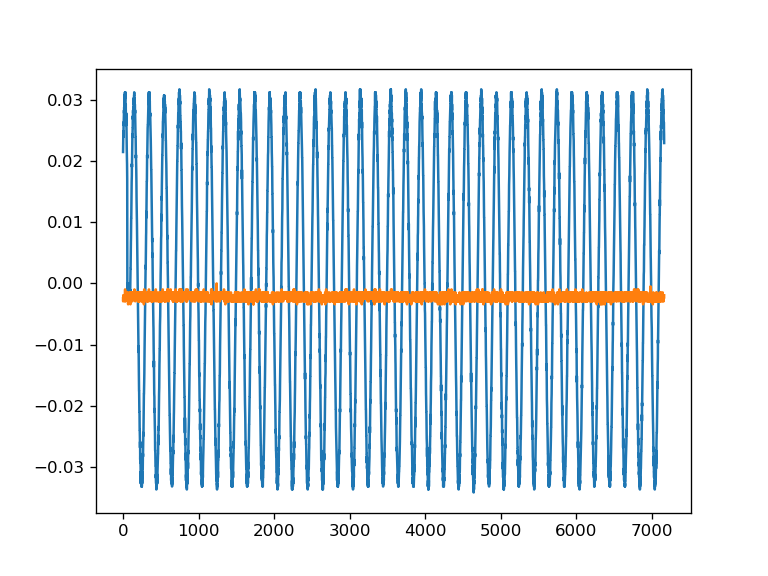

In [146]:
fig, ax = plt.subplots(1,1)
ax.plot(d[1][1])

In [18]:
34.56*250

8640.0

In [10]:
dll_wait_calls_moments = [16.110345707360633, 16.15533883778866, 16.200323170472423, 16.245338295261096, 16.290342667251227, 16.335333842624973, 16.38031915283588, 16.42533036751599, 16.470341093432534, 16.515286813794276]
handle_buffer_calls_moments = [16.12008627654536, 16.164854575731226, 16.209569599687974, 16.25492685897558, 16.29999086012124, 16.344823187334768, 16.389579756194955, 16.434500549614633, 16.479698471978452, 16.524600692382474]
dll_repost_calls_moments = [16.120381489741586, 16.165140502419625, 16.20985748143065, 16.255241622714603, 16.300309045205253, 16.345124265693833, 16.389866171646922, 16.43479722910157, 16.480039628950248, 16.52489150670657]

<IPython.core.display.Javascript object>


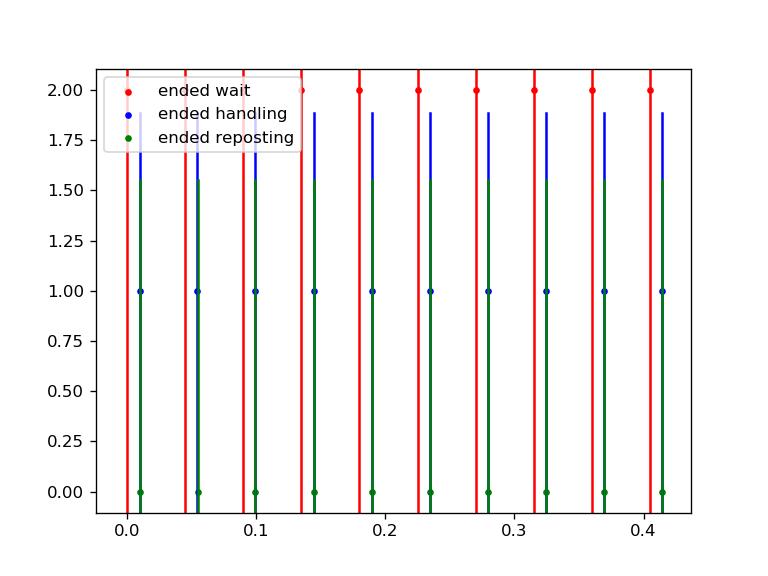

In [11]:
dll_wait_calls_moments = np.array(dll_wait_calls_moments)
handle_buffer_calls_moments = np.array(handle_buffer_calls_moments)
dll_repost_calls_moments = np.array(dll_repost_calls_moments)

dll_wait_calls_moments_rel = dll_wait_calls_moments - dll_wait_calls_moments[0]
handle_buffer_calls_moments_rel = handle_buffer_calls_moments - dll_wait_calls_moments[0]
dll_repost_calls_moments_rel = dll_repost_calls_moments - dll_wait_calls_moments[0]

fig, ax = plt.subplots(1,1)

ax.scatter(dll_wait_calls_moments_rel, [2]*len(dll_wait_calls_moments_rel), label='ended wait', marker='.', color='red')
for xx in dll_wait_calls_moments_rel:
    plt.axvline(x=xx, color='red')
    
ax.scatter(handle_buffer_calls_moments_rel, [1]*len(handle_buffer_calls_moments_rel), label='ended handling', marker='.', color='blue')
for xx in handle_buffer_calls_moments_rel:
    plt.axvline(x=xx, color='blue', ymax=0.90)
    
ax.scatter(dll_repost_calls_moments_rel, [0]*len(dll_repost_calls_moments_rel), label='ended reposting', marker='.', color='green')
for xx in dll_repost_calls_moments_rel:
    plt.axvline(x=xx, color='green', ymax=0.75)
    
ax.legend()

In [112]:
nrecords = np.array([10, 20, 50, 100, 200, 500, 1000])
sr_vals = np.array([50e6, 100e6, 200e6, 500e6, 1e9])

times = np.zeros((sr_vals.size, nrecords.size))
samples_per_record = np.zeros((sr_vals.size, nrecords.size))
overheads = np.zeros((sr_vals.size, nrecords.size))

for j, sr in enumerate(sr_vals):
    for i, nr in enumerate(nrecords):
        times[j, i], samples_per_record[j, i], overheads[j, i] = \
            time_acquisition(n_records_per_buffer=nr, SR=sr)

Allocating 2000000000 elements (4000.0 MB)
done: 0.5286841377273959 s
Setup capture: 153.6 MB total
 * Buffers: 10000 (0.01536 MB/buffer) | (Allocated buffers: {nalloc} = {mbpalloc} MB)
 * Records: 10 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.7325840895318834 s
Net time: 1.0 sec.
Acquistion: 5.1 sec.
Overhead: 5.1 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.10022952393410378 s
Setup capture: 153.6 MB total
 * Buffers: 5000 (0.03072 MB/buffer) | (Allocated buffers: {nalloc} = {mbpalloc} MB)
 * Records: 20 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5976292953855591 s
Net time: 1.0 sec.
Acquistion: 3.2 sec.
Overhead: 3.2 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11040853891609004 s
Setup capture: 153.60000000000002 MB total
 * Buffers: 2000 (0.07680000000000001 MB/buffer) | (Allocated buffers: {nalloc} = {mbpalloc} MB)
 * Records: 50 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.591235

Setup capture: 1791.9999999999998 MB total
 * Buffers: 2000 (0.8959999999999999 MB/buffer) | (Allocated buffers: {nalloc} = {mbpalloc} MB)
 * Records: 50 (0.01792 MB/record)
 * Samples: 4480 (= 8.96 us)
 * Channels: 2
done: 0.5894688788830535 s
Net time: 1.0 sec.
Acquistion: 9.9 sec.
Overhead: 9.9 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.24832035988583812 s
Setup capture: 1791.9999999999998 MB total
 * Buffers: 1000 (1.7919999999999998 MB/buffer) | (Allocated buffers: {nalloc} = {mbpalloc} MB)
 * Records: 100 (0.01792 MB/record)
 * Samples: 4480 (= 8.96 us)
 * Channels: 2
done: 0.5989680220773153 s
Net time: 1.0 sec.
Acquistion: 10.0 sec.
Overhead: 10.0 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.2504298686108086 s
Setup capture: 1791.9999999999998 MB total
 * Buffers: 500 (3.5839999999999996 MB/buffer) | (Allocated buffers: {nalloc} = {mbpalloc} MB)
 * Records: 200 (0.01792 MB/record)
 * Samples: 4480 (= 8.96 us)
 * Channels: 2
done: 0.5996923714556033 s
Net time:

c:\users\administrator\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:831: RuntimeWarning: overflow encountered in long_scalars
  bytes_transferred += buf.size_bytes


Net time: 1.0 sec.
Acquistion: 21.7 sec.
Overhead: 21.7 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.4429547980580537 s
Setup capture: 3583.9999999999995 MB total
 * Buffers: 5000 (0.7167999999999999 MB/buffer) | (Allocated buffers: {nalloc} = {mbpalloc} MB)
 * Records: 20 (0.03584 MB/record)
 * Samples: 8960 (= 8.96 us)
 * Channels: 2
done: 0.6014709864321048 s
Net time: 1.0 sec.
Acquistion: 22.9 sec.
Overhead: 22.9 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.41067384043344646 s
Setup capture: 3583.9999999999995 MB total
 * Buffers: 2000 (1.7919999999999998 MB/buffer) | (Allocated buffers: {nalloc} = {mbpalloc} MB)
 * Records: 50 (0.03584 MB/record)
 * Samples: 8960 (= 8.96 us)
 * Channels: 2
done: 0.5997686187583895 s
Net time: 1.0 sec.
Acquistion: 21.6 sec.
Overhead: 21.6 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.4217834635237523 s
Setup capture: 3583.9999999999995 MB total
 * Buffers: 1000 (3.5839999999999996 MB/buffer) | (Allocated buffers: {nalloc} = {

<IPython.core.display.Javascript object>


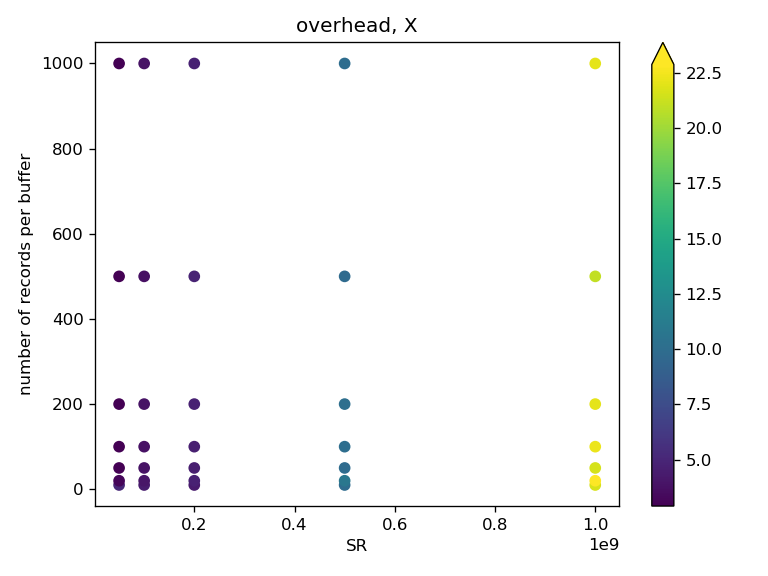

In [113]:
# fig, (ax_overheads, ax_samples_per_record) = plt.subplots(2, 1)
fig, ax_overheads = plt.subplots(1, 1)

nrecords_grid, sr_vals_grid = np.meshgrid(nrecords, sr_vals)

# p_overheads = ax_overheads.pcolormesh(
#     sr_vals_grid, nrecords_grid, overheads,)
#     norm=colors.LogNorm(vmin=overheads.min(), vmax=overheads.max()),
# )
# fig.colorbar(p_overheads, ax=ax_overheads, extend='max')
p_overheads = ax_overheads.scatter(
    sr_vals_grid, nrecords_grid, c=overheads)
#     norm=colors.LogNorm(vmin=overheads.min(), vmax=overheads.max())
# )
fig.colorbar(p_overheads, ax=ax_overheads, extend='max')

ax_overheads.set_xlabel('SR')
ax_overheads.set_ylabel('number of records per buffer')
ax_overheads.set_title('overhead, X')

# # p_samples_per_record = ax_samples_per_record.pcolormesh(
# #     sr_vals_grid, nrecords_grid, samples_per_record,)
# #     norm=colors.LogNorm(vmin=samples_per_record.min(), vmax=samples_per_record.max())
# # ) 
# # fig.colorbar(p_samples_per_record, ax=ax_samples_per_record, extend='max')
# p_samples_per_record = ax_samples_per_record.scatter(
#     sr_vals_grid, nrecords_grid, c=samples_per_record)
# fig.colorbar(p_samples_per_record, ax=ax_samples_per_record)

# ax_samples_per_record.set_xlabel('SR')
# ax_samples_per_record.set_ylabel('number of records per buffer')
# ax_samples_per_record.set_title('samples per record')

fig.tight_layout()

Regardless of the number of records per buffer, the overhead scales linearly with the SR. This can probably be explained by the simple fact of the data size growing with SR, hence it takes more time to transfer and process *more* data.

<IPython.core.display.Javascript object>


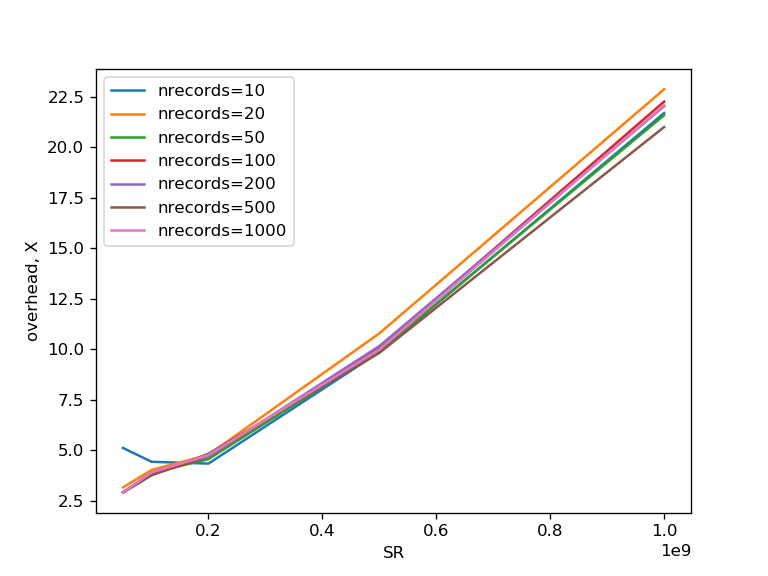

In [116]:
fig, ax = plt.subplots(1,1)

for i, nr in enumerate(nrecords):
    ax.plot(sr_vals_grid[:,i], overheads[:,i], label=f'nrecords={nr}')

ax.set_xlabel('SR')
ax.set_ylabel('overhead, X')

ax.legend()

There is no dependency of the overhead on the number of records per buffer after ~20-50.

<IPython.core.display.Javascript object>


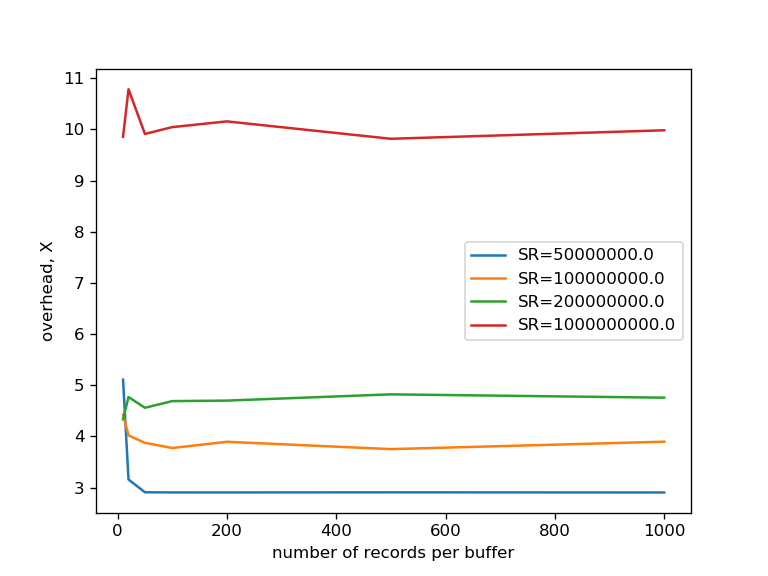

Text(0,0.5,'overhead, X')

In [117]:
fig, ax = plt.subplots(1,1)

for i, sr in enumerate(sr_vals):
    ax.plot(nrecords_grid[i,:], overheads[i,:], label=f'SR={sr}')

ax.legend()

ax.set_xlabel('number of records per buffer')
ax.set_ylabel('overhead, X')

Let's look into numbers of records per buffer that are close to 1.

In [121]:
nrecords = np.array([1, 2, 3, 5, 10, 15, 20, 40])
sr_vals = np.array([50e6, 100e6])

times = np.zeros((sr_vals.size, nrecords.size))
samples_per_record = np.zeros((sr_vals.size, nrecords.size))
overheads = np.zeros((sr_vals.size, nrecords.size))

for j, sr in enumerate(sr_vals):
    for i, nr in enumerate(nrecords):
        times[j, i], samples_per_record[j, i], overheads[j, i] = \
            time_acquisition(n_records_per_buffer=nr, SR=sr)

Allocating 2000000000 elements (4000.0 MB)
done: 0.011202488400158472 s
Setup capture: 153.6 MB total
 * Buffers: 100000 (0.001536 MB/buffer) | (Allocated buffers: 5 = 0.00768 MB)
 * Records: 1 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.7320303190572304 s
Net time: 1.0 sec.
Acquistion: 4.8 sec.
Overhead: 4.8 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.12483149834588403 s
Setup capture: 153.6 MB total
 * Buffers: 50000 (0.003072 MB/buffer) | (Allocated buffers: 5 = 0.01536 MB)
 * Records: 2 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.59896313443096 s
Net time: 1.0 sec.
Acquistion: 2.9 sec.
Overhead: 2.9 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11190758044904214 s
Setup capture: 153.598464 MB total
 * Buffers: 33333 (0.004608 MB/buffer) | (Allocated buffers: 5 = 0.02304 MB)
 * Records: 3 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.592363832580304 s
Net time: 1.0 sec.
Acquistion: 3.4 

For very low numbers of records per buffer, the overhead is bigger than for higher numbers, and also behaves quite funky. Some further investigation is necessary.

<IPython.core.display.Javascript object>


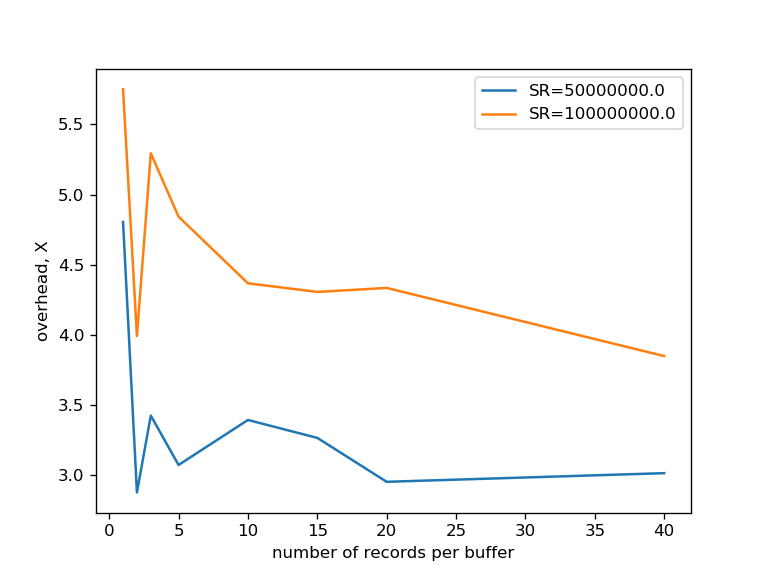

Text(0,0.5,'overhead, X')

In [126]:
nrecords_grid, sr_vals_grid = np.meshgrid(nrecords, sr_vals)

fig, ax = plt.subplots(1,1)

for i, sr in enumerate(sr_vals):
    ax.plot(nrecords_grid[i,:], overheads[i,:], label=f'SR={sr}')

ax.legend()

ax.set_xlabel('number of records per buffer')
ax.set_ylabel('overhead, X')

In [131]:
time_acquisition(n_records_per_buffer=1, SR=50e6)

Allocating 2000000000 elements (4000.0 MB)
done: 0.09977106258520507 s
Setup capture: 153.6 MB total
 * Buffers: 100000 (0.001536 MB/buffer) | (Allocated buffers: 5 = 0.00768 MB)
 * Records: 1 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5944625884803827 s
Net time: 1.0 sec.
Acquistion: 4.6 sec.
Overhead: 4.6 X


(4.612489699284197, 384, 4.612489699284197)

# Effect of allocated buffers

In [135]:
t_rep = 10e-6  # this is the rep-rate of the AWG test sequence
acq_time = 9e-6  # time it takes to measure raw data by Alazar 
                 # for a single measurement point (i.e. it is to be demodulated later)
npts = int(1e5)  # number of "measurement points"

In [136]:
t_net_total = npts * t_rep

def time_acquisition(n_records_per_buffer = 50, 
                     SR = 50e6,
                     alloc_buffers = 5):
    """
    alloc_buffers: number of buffers to allocate in the Alazar card memory
    """
    t0 = time.perf_counter()
    ctl.allocate_data(int(2e9))
    t1 = time.perf_counter()
    print("done:", t1 - t0, 's')

    nbuffers = npts // n_records_per_buffer
    ctl.setup_acquisition(samples_per_record=None, 
                          records=n_records_per_buffer, 
                          buffers=nbuffers, 
                          acq_time=acq_time, 
                          allocated_buffers=alloc_buffers, 
                          SR=int(SR))
    t2 = time.perf_counter()
    print("done:",  t2 - t1, 's')
    
    t0 = time.perf_counter()
    data = ctl.acquisition() 
    t1 = time.perf_counter()
    
    t_acq_total = t1 - t0
    overhead = t_acq_total / t_net_total

    print(f'Net time: {t_net_total:.1f} sec.')
    print(f'Acquistion: {t_acq_total:.1f} sec.')
    print(f'Overhead: {overhead:.1f} X')
    
    return overhead

In [137]:
nrecords = np.array([1, 2, 3, 5, 7, 10, 20, 50, 100, 200, 500])
alloc_buffers = np.array([1, 2, 3, 5, 7, 10])

overheads = np.zeros((alloc_buffers.size, nrecords.size))

for j, allocb in enumerate(alloc_buffers):
    for i, nr in enumerate(nrecords):
        overheads[j, i] = time_acquisition(n_records_per_buffer=nr, 
                                           SR=50e6,
                                           alloc_buffers=allocb)

Allocating 2000000000 elements (4000.0 MB)
done: 0.1084353955629922 s
Setup capture: 153.6 MB total
 * Buffers: 100000 (0.001536 MB/buffer) | (Allocated buffers: 1 = 0.001536 MB)
 * Records: 1 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5992798539955402 s
Net time: 1.0 sec.
Acquistion: 12.1 sec.
Overhead: 12.1 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.1095898579369532 s
Setup capture: 153.6 MB total
 * Buffers: 50000 (0.003072 MB/buffer) | (Allocated buffers: 1 = 0.003072 MB)
 * Records: 2 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5959362142421014 s
Net time: 1.0 sec.
Acquistion: 6.5 sec.
Overhead: 6.5 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11215245159473852 s
Setup capture: 153.598464 MB total
 * Buffers: 33333 (0.004608 MB/buffer) | (Allocated buffers: 1 = 0.004608 MB)
 * Records: 3 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.6004807490244275 s
Net time: 1.0 sec.
Acquistion:

Net time: 1.0 sec.
Acquistion: 2.9 sec.
Overhead: 2.9 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.10841633373638615 s
Setup capture: 153.598464 MB total
 * Buffers: 33333 (0.004608 MB/buffer) | (Allocated buffers: 3 = 0.013824 MB)
 * Records: 3 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5942685488662391 s
Net time: 1.0 sec.
Acquistion: 4.2 sec.
Overhead: 4.2 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.10833275496406714 s
Setup capture: 153.6 MB total
 * Buffers: 20000 (0.00768 MB/buffer) | (Allocated buffers: 3 = 0.02304 MB)
 * Records: 5 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.6051025086344453 s
Net time: 1.0 sec.
Acquistion: 3.5 sec.
Overhead: 3.5 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.10260736451164121 s
Setup capture: 153.59232000000003 MB total
 * Buffers: 14285 (0.010752000000000001 MB/buffer) | (Allocated buffers: 3 = 0.03225600000000001 MB)
 * Records: 7 (0.001536 MB/record)
 * Samples:

Setup capture: 153.6 MB total
 * Buffers: 20000 (0.00768 MB/buffer) | (Allocated buffers: 7 = 0.05376 MB)
 * Records: 5 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5978937171239522 s
Net time: 1.0 sec.
Acquistion: 3.6 sec.
Overhead: 3.6 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11140855162375374 s
Setup capture: 153.59232000000003 MB total
 * Buffers: 14285 (0.010752000000000001 MB/buffer) | (Allocated buffers: 7 = 0.07526400000000001 MB)
 * Records: 7 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.6044685807355563 s
Net time: 1.0 sec.
Acquistion: 3.4 sec.
Overhead: 3.4 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11055321328603895 s
Setup capture: 153.6 MB total
 * Buffers: 10000 (0.01536 MB/buffer) | (Allocated buffers: 7 = 0.10752 MB)
 * Records: 10 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.6003106588868832 s
Net time: 1.0 sec.
Acquistion: 3.3 sec.
Overhead: 3.3 X
Allocating 2000000

<IPython.core.display.Javascript object>


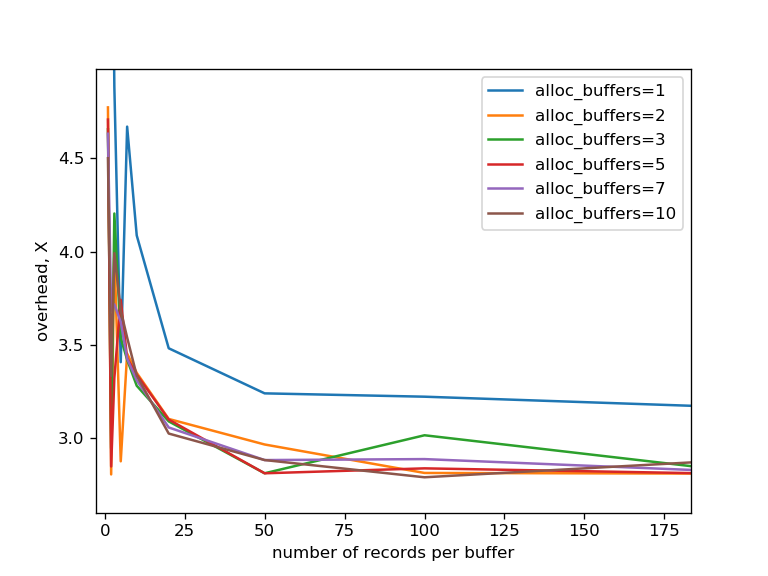

Text(0,0.5,'overhead, X')

In [138]:
nrecords_grid, alloc_buffers_grid = np.meshgrid(nrecords, alloc_buffers)

fig, ax = plt.subplots(1,1)

for i, allb in enumerate(alloc_buffers):
    ax.plot(nrecords_grid[i,:], overheads[i,:], label=f'alloc_buffers={allb}')

ax.legend()

ax.set_xlabel('number of records per buffer')
ax.set_ylabel('overhead, X')